# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [18]:
import artm

In [19]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [20]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [21]:
# Ваш код
# batch_vectorizer = artm.BatchVectorizer(data_path="D:\Coursera_ML\HA 3.4\lectures.txt", data_format="vowpal_wabbit", target_folder="lectures_batches", 
#                                        batch_size=100)
batch_vectorizer = artm.BatchVectorizer(data_path='../../data/lectures.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='lectures_batches')

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [22]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1,'author':1},cache_theta=True,reuse_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [23]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [24]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name='TTScore_text', class_id="text",num_tokens=15))
model_artm.scores.add(artm.TopTokensScore(name='TTScore_author', class_id="author",num_tokens=15))

In [25]:
# Code from tutorial to monitor topics phi sparsity.
model_artm.scores.add(
    artm.SparsityPhiScore(
        name='sparsity_phi_score_sbj',
        class_id='text',
        topic_names=model_artm.topic_names[0:29]
    )
)
model_artm.scores.add(
    artm.SparsityPhiScore(
        name='sparsity_phi_score_bcg',
        class_id='text',
        topic_names=model_artm.topic_names[29:]
    )
)

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [26]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=1e5, dictionary=dictionary,class_ids='text',topic_names=['bcg']))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [27]:
# Ваш код
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

sbj sparsity: 0.7797842025756836
bcg sparsity: 0.8015345335006714


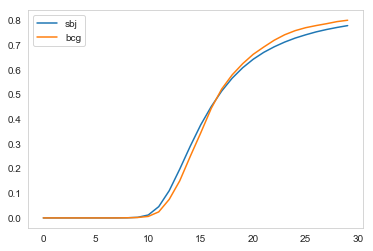

In [28]:
plt.plot(model_artm.score_tracker['sparsity_phi_score_sbj'].value, label='sbj')
plt.plot(model_artm.score_tracker['sparsity_phi_score_bcg'].value, label='bcg')
plt.legend(loc='best');
print('sbj sparsity:', model_artm.score_tracker['sparsity_phi_score_sbj'].last_value)
print('bcg sparsity:', model_artm.score_tracker['sparsity_phi_score_bcg'].last_value)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [29]:
# Ваш код
sbj=list(set(topic_names)-set('bcg'))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e5, dictionary=dictionary,class_ids='text',topic_names=sbj))

Выполните еще 15 проходов по коллекции.

In [30]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [31]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["TTScore_text"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-31-12d17ba76bc8>, line 3)

In [32]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["TTScore_author"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-32-5934bc06af81>, line 3)

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [33]:
sbj_topic_labels = []   # запишите названия тем в список
for topic_name in model_artm.topic_names[:-1]:
    tokens = model_artm.score_tracker["TTScore_text"].last_tokens
    sbj_topic_labels.append(tokens[topic_name][0])

topic_labels = sbj_topic_labels + [u'Фоновая тема']

In [34]:
model_artm.topic_names=topic_labels

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [35]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta()
print(theta.shape)
phi_a = model_artm.get_phi(class_ids='author')
print(phi_a.shape)

(30, 1728)
(539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

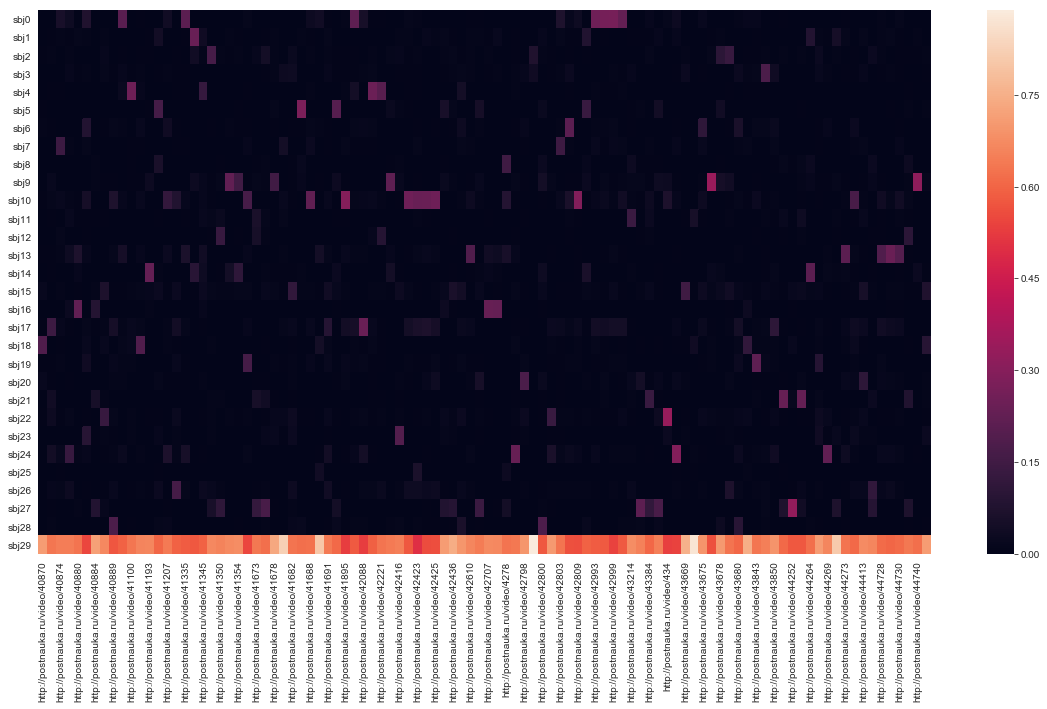

In [36]:
# Ваш код
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(theta.iloc[:,:100])
plt.show()

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [37]:
# Ваш код
import pandas as pd

T=(theta.apply(lambda x: np.sum(x),axis=1))
T.index=topic_labels
T=pd.DataFrame(T/np.sum(T),columns=['p(t)'])
T

,p(t)
власть,0.013168
земля,0.013936
система,0.011335
культура,0.017115
право,0.009540
материал,0.011434
книга,0.009394
смерть,0.005412
метод,0.015084
частица,0.028208


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

In [38]:
# Ваш код
print(T['p(t)'].sort_values()[-6:-1])
print(T['p(t)'].sort_values()[0:3])

задача          0.019086
политический    0.021049
звезда          0.022264
клетка          0.027408
частица         0.028208
Name: p(t), dtype: float64
программа    0.003800
раса         0.004837
смерть       0.005412
Name: p(t), dtype: float64


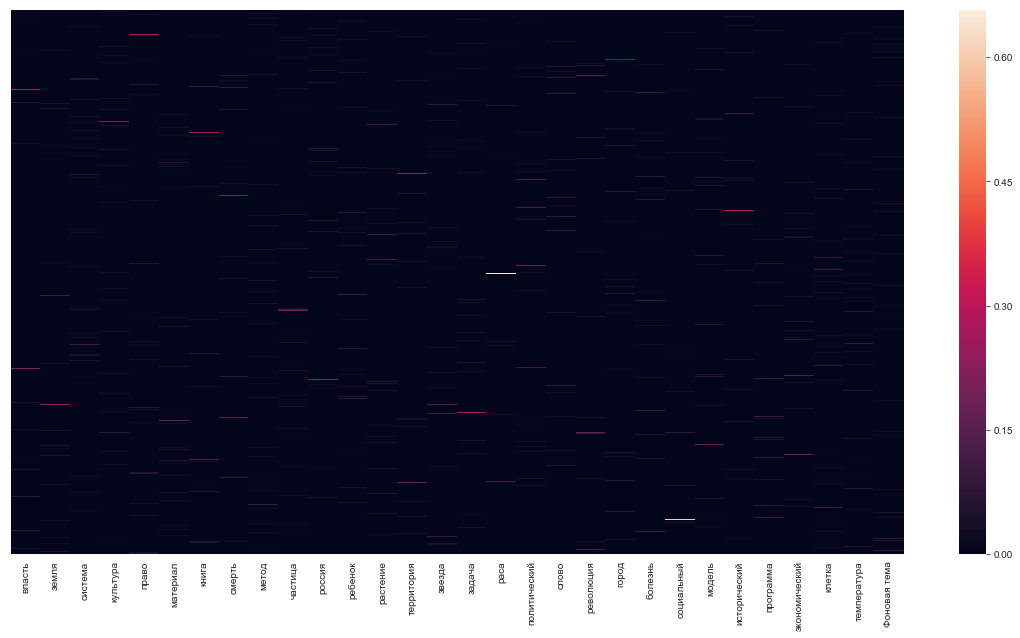

In [39]:
# Ваш код

import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(phi_a,yticklabels=False)
plt.show()

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [40]:
A=phi_a.apply(lambda x: sum(x>0.01),axis=1)
A[A>=3]

Ольга_Тогоева          3
Дмитрий_Лось           3
Алина_Бодрова          3
Шринивас_Шридхар       3
Михаил_Алексеевский    3
Михаил_Соколов         3
Дина_Гусейнова         3
Александр_Филиппов     3
Михаил_Маяцкий         4
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [41]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [42]:
# Ваш код
P_a=pd.DataFrame(np.dot(phi_a,T),index=phi_a.index,columns=['p(a)'])
concat1=pd.concat([phi_a, P_a], axis=1)
concat2=pd.concat([concat1, T.transpose()], axis=0)
concat2.ix['p(t)',0]=1
c1=concat2.apply(lambda x: x*x[-1],axis=0)
c2=c1.apply(lambda x: x/x[0],axis=1)
A_profiles=c2.ix[:-1,1:]

/Users/artem/miniconda3/envs/bigartm/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.
/Users/artem/miniconda3/envs/bigartm/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/Users/artem/miniconda3/envs/bigartm/lib/python3.5/site-packages/pandas/core/indexing.py:890: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexin

Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [45]:
A_profiles

,Фоновая тема,болезнь,власть,город,задача,звезда,земля,исторический,клетка,книга,...,революция,россия,система,слово,смерть,социальный,температура,территория,частица,экономический
Дэвид_Гросс,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
Павел_Степанцов,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Ирина_Каспэ,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Александр_Беленький,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Татьяна_Гусарова,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Андрей_Коротаев,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Галина_Зеленина,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.999998e-01,0.000000e+00,0.000000,...,1.630959e-11,2.288094e-07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Ирина_Левонтина,0.000000,4.888622e-10,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.410735e-01,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Алексей_Малашенко,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.812384e-07,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.760834e-05,0.000000e+00,0.000000e+00
Дэвид_Кларк,0.000000,0.000000e+00,0.000000,4.001559e-06,9.999960e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [43]:
# Ваш код
estimator=MDS(n_components=2,dissimilarity='precomputed')
data=estimator.fit_transform(pairwise_distances(A_profiles,metric='cosine'))

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


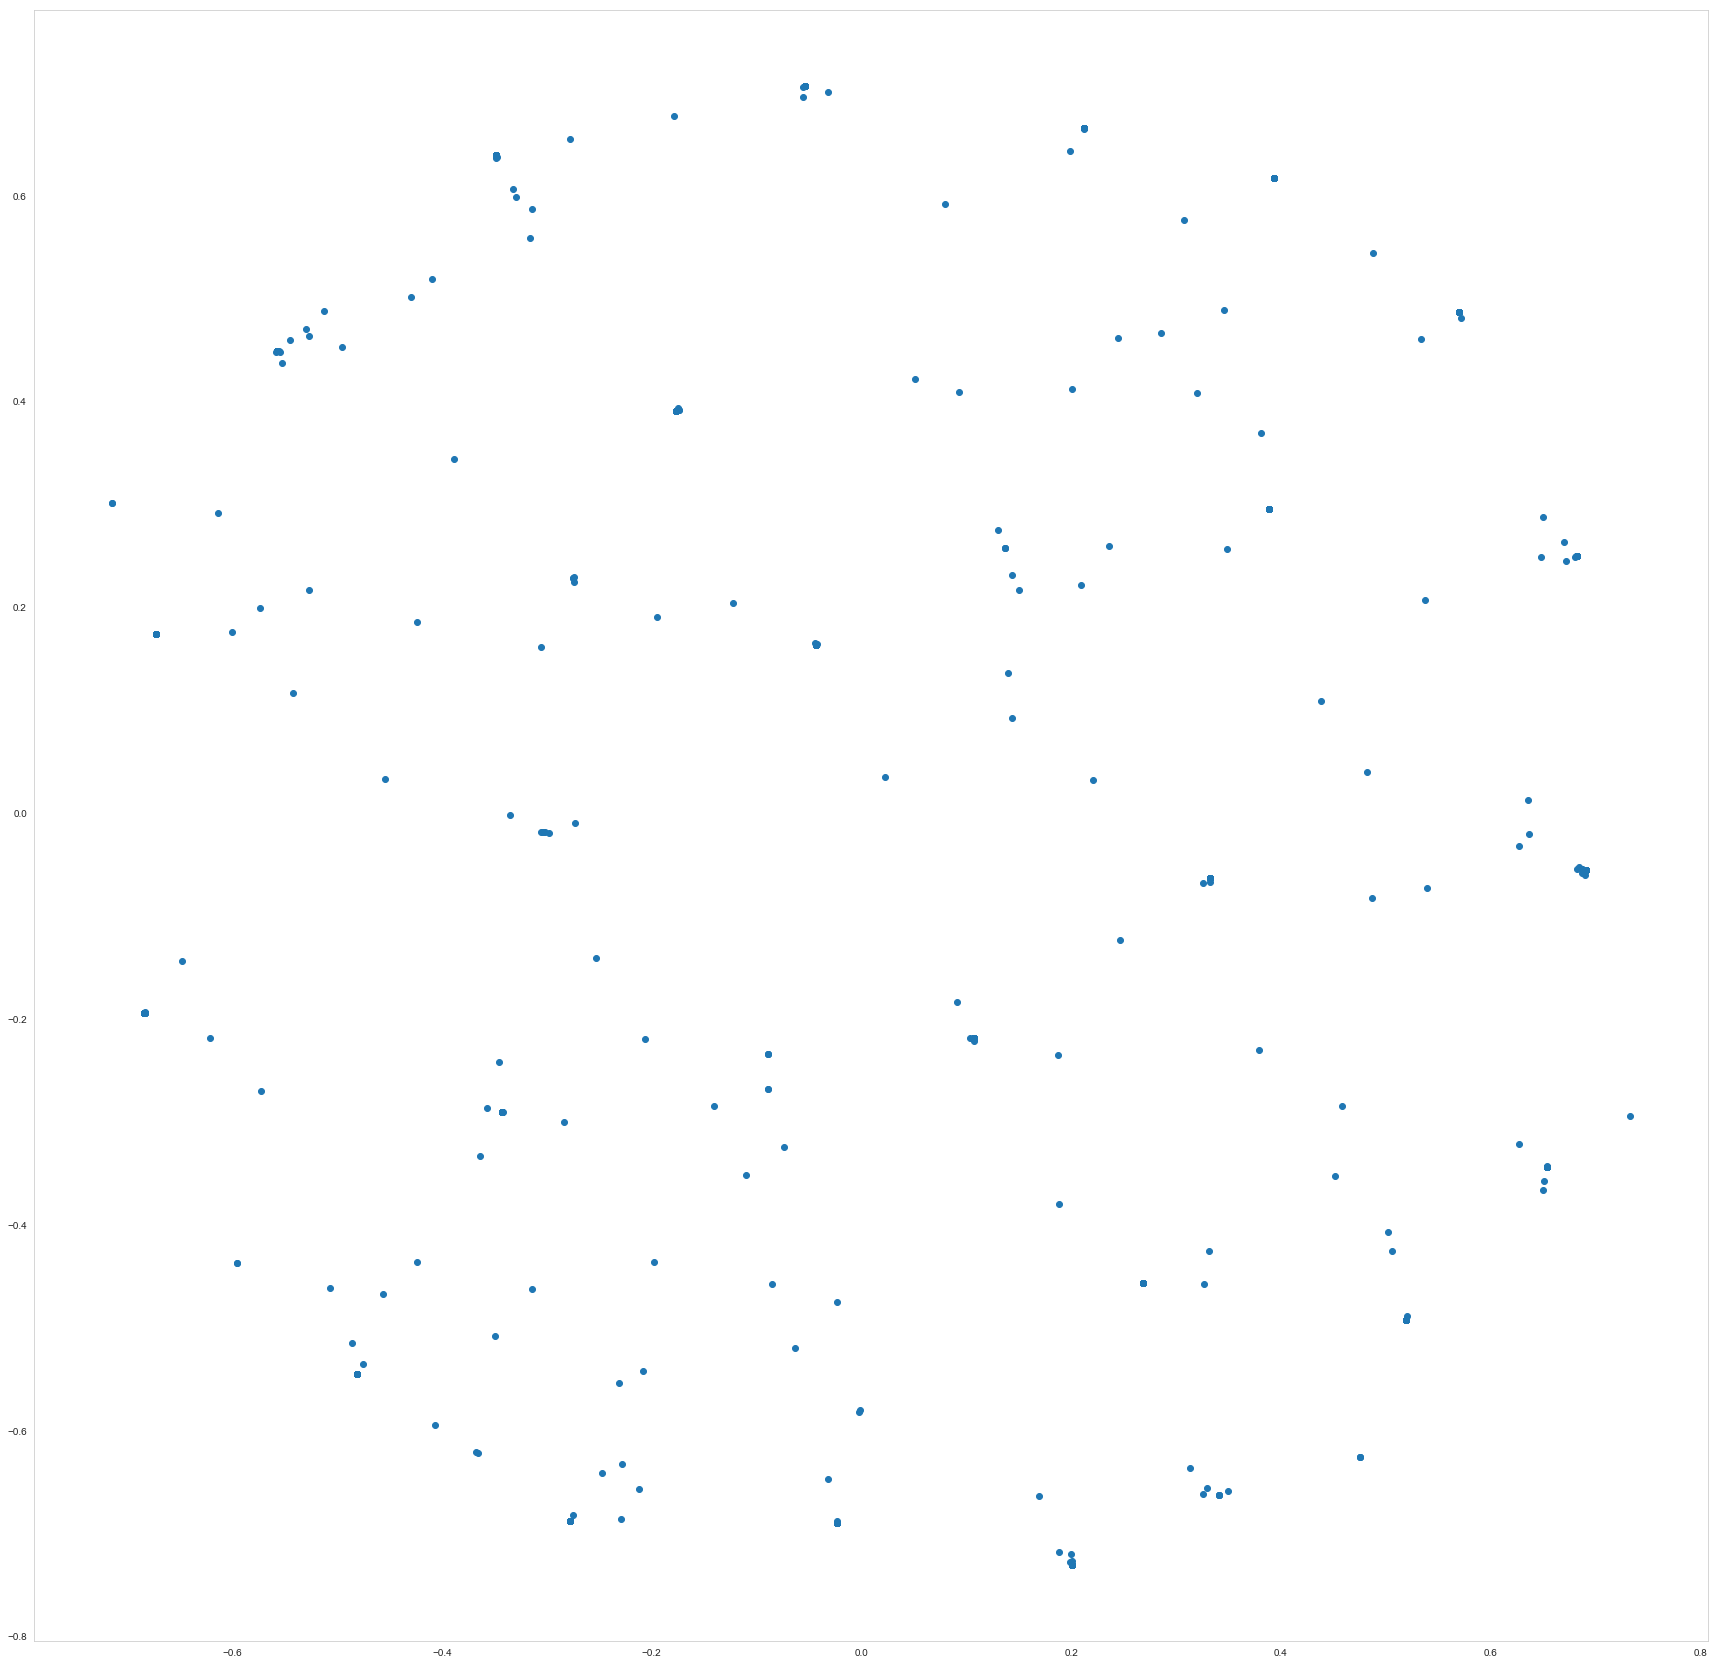

In [44]:
%pylab
figsize(30,30)
scatter(data[:,0],data[:,1])
show()

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

/Users/artem/miniconda3/envs/bigartm/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """


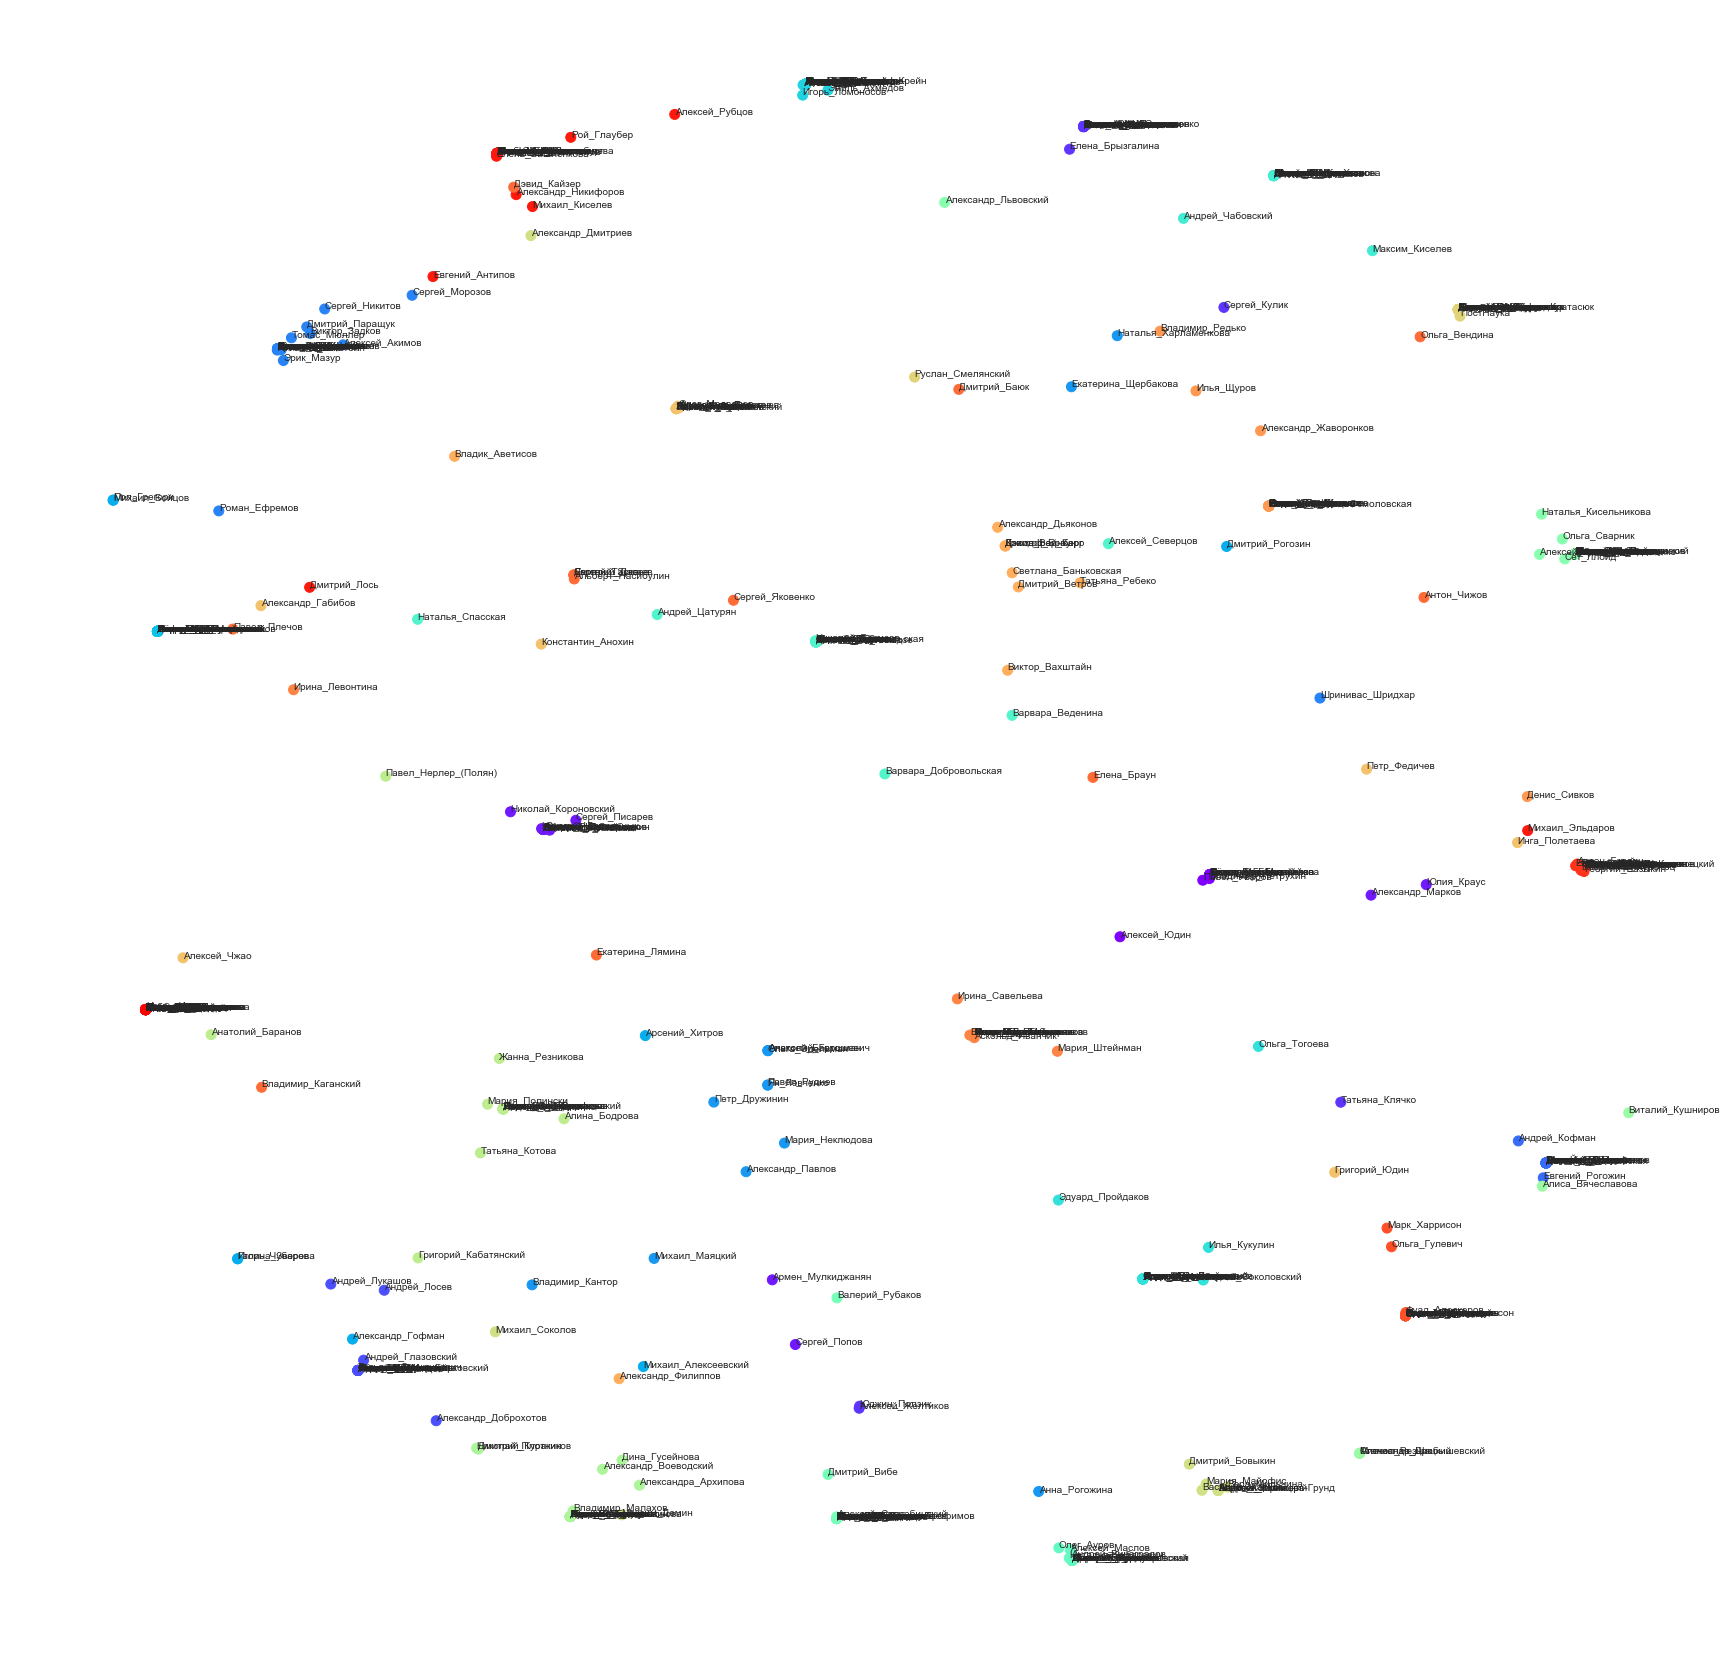

In [46]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(T)))
phi_a.index=[ind for ind,val in enumerate(phi_a.index)]
phi_a.columns=[ind for ind,val in enumerate(phi_a.columns)]
nearest = np.array(phi_a.apply(lambda x: x.argmax(),axis=1))
plt.figure(figsize=(30,30))
plt.axis('off')
scatter(data[:,0],data[:,1],s=100, c=colors[nearest])
for i, author in enumerate(P_a.index):
        plt.annotate(author, data[i])
plt.savefig(r'''D:\Coursera_ML\HA 3.4\authors_map.pdf''', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [301]:
# Ваш код
theta.index=topic_labels
P_d_t=theta.apply(lambda x: x/np.sum(x))
mx_prob=P_d_t.apply(lambda x: x.argmax(),axis=1)


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  after removing the cwd from sys.path.


,http://postnauka.ru/video/22977,http://postnauka.ru/video/22978,http://postnauka.ru/video/23077,http://postnauka.ru/video/23079,http://postnauka.ru/video/23111,http://postnauka.ru/video/23161,http://postnauka.ru/video/23163,http://postnauka.ru/video/23172,http://postnauka.ru/video/23233,http://postnauka.ru/video/23253,...,http://postnauka.ru/video/9874,http://postnauka.ru/video/9876,http://postnauka.ru/video/9968,http://postnauka.ru/video/9992,http://postnauka.ru/video/9993,http://postnauka.ru/video/9994,http://postnauka.ru/video/9995,http://postnauka.ru/video/9996,http://postnauka.ru/video/9997,http://postnauka.ru/video/9998
власть,5.431673e-10,5.918203e-15,0.000000e+00,0.000000e+00,4.441254e-10,0.007970,0.000000e+00,0.000000e+00,6.525259e-02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.284355,2.797549e-03,1.596833e-14,0.000000e+00,2.866584e-04,0.000000e+00,0.000000e+00,0.000000e+00
земля,4.027652e-02,5.388455e-03,7.437693e-03,0.000000e+00,9.353401e-02,0.000000,0.000000e+00,1.555192e-02,0.000000e+00,9.751944e-11,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.959622e-03,6.229646e-04,3.186119e-02,0.000000e+00,0.000000e+00,0.000000e+00
система,5.746120e-03,1.086957e-02,0.000000e+00,1.023363e-10,6.172844e-03,0.008572,6.217738e-03,0.000000e+00,2.456987e-06,4.329650e-02,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,1.489848e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
культура,0.000000e+00,0.000000e+00,1.557914e-02,2.459800e-02,6.526163e-03,0.033337,6.306738e-02,2.608778e-16,4.560326e-02,0.000000e+00,...,2.042357e-01,0.000000e+00,0.000000,0.000000e+00,2.245317e-11,6.366605e-02,5.509054e-03,0.000000e+00,5.317041e-02,2.444534e-02
право,5.732441e-03,1.447152e-03,0.000000e+00,1.408451e-02,0.000000e+00,0.010087,0.000000e+00,0.000000e+00,0.000000e+00,2.993898e-14,...,0.000000e+00,0.000000e+00,0.064516,4.765081e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
материал,2.047363e-02,0.000000e+00,0.000000e+00,0.000000e+00,2.452939e-02,0.000000,0.000000e+00,0.000000e+00,4.508641e-08,3.357279e-02,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,8.057186e-03,4.276472e-02,0.000000e+00,3.020347e-02,0.000000e+00,1.030730e-16
книга,2.518962e-15,0.000000e+00,0.000000e+00,6.660479e-07,0.000000e+00,0.063133,2.103634e-02,2.208692e-02,1.494455e-02,0.000000e+00,...,3.030303e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.374547e-02,0.000000e+00,0.000000e+00,0.000000e+00
смерть,6.060480e-03,1.430158e-02,9.450706e-03,0.000000e+00,3.142832e-13,0.000000,4.624790e-07,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,5.310018e-12,0.000000e+00,2.070411e-09,0.000000e+00,3.784686e-14,0.000000e+00
метод,0.000000e+00,1.470210e-14,1.848401e-02,0.000000e+00,1.490801e-02,0.009559,0.000000e+00,3.550430e-03,0.000000e+00,2.607492e-01,...,0.000000e+00,3.124997e-02,0.000000,0.000000e+00,1.096682e-01,1.507836e-01,5.310500e-03,8.523703e-02,0.000000e+00,3.337523e-02
частица,1.190365e-02,0.000000e+00,7.747017e-03,4.378259e-05,1.183475e-10,0.005394,0.000000e+00,6.384521e-02,0.000000e+00,5.827196e-02,...,5.221424e-02,0.000000e+00,0.000000,0.000000e+00,6.357938e-03,5.418323e-12,0.000000e+00,0.000000e+00,0.000000e+00,2.190773e-05


Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [299]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [300]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [316]:
# Ваш код
import warnings
warnings.filterwarnings("ignore")
dc={'sbj'+str(num):val for num,val in enumerate(topic_labels[:-1])}
dc['bcg']=topic_labels[-1]

for name in dc:
    display(HTML(u'<h1>'+dc[name]+u'</h1>'))
    display(HTML(u'<font>Ключевые слова:</font>'))
    tokens = model_artm.score_tracker["TTScore_text"].last_tokens
    for word in tokens[name]:    
        print word,
    print
    display(HTML(u'<font>Ссылки:</font>'))
    for item in list((P_d_t.ix[dc[name]].sort_values(ascending=False)[:10]).index):
        display(HTML(u'<ul><li>'+item+'</li></ul>'))


 задача информация данные память решение анализ компьютер решать внимание психология мышление ошибка оценка деньги следующий


звезда галактика объект черный волна масса свет скорость вселенная дыра излучение расстояние вещество размер телескоп


политический общество философия государство философский практика философ институт партия организация правовой политика ключевой повлиять идеология


раса африка америка остров южный станислав волос нос индия структурный монголоид дробышевский рост штамм индеец


ребенок возраст конфликт кровь взрослый молодой мать сон родитель семья защищать страшный катастрофа старение травма


россия война советский российский власть германия страна мировой против историк немецкий реформа петр государственный военный


территория христианский империя народ восток древний письменность регион традиция цивилизация китай памятник христианство северный восточный


растение орган сердце рак озеро стадия опухоль вода нейронный птица мышца инженерия линзовидный печень экосистема


революция французский свобода роль франция роман национальный аргумент костюм вовсе сцена нация творчество король общественный


слово текст словарь категория значение предложение конструкция корпус глагол грамматика лицо поэт контекст устный синтаксический


температура университет магнитный профессор сверхпроводимость ток дальнейший студент сверхпроводник металл канал сверхпроводящий низкий электроника железо


исторический бог миф царь история греческий представление религиозный эпоха спор сюжет имя религия море душа


программа гласный согласный говор программирование компилятор игра мягкий жест твердость ричард интегрировать галилей столыпин программист


экономический страна экономика выбор ценность ресурс идентичность решение кризис проводиться принятие сталин коллективный процедура влияние


клетка мозг организм ген днк белок биологический животное генетический нейрон молекулярный геном биология лаборатория бактерия


город технология сеть проект пространство робот городской интернет управление компания пользователь музей технологический библиотека медиа


болезнь заболевание пациент лечение медицина операция врач боль женщина препарат медицинский мужчина нарушение больной диагностика


социальный знание объект научный социология смысл дисциплина социологический познание обучение описание объяснение перевод применять виктор


модель сообщество схема матрица микроорганизм эмоция интеллект алгоритм вычислительный эмоциональный функция глубина осуществлять машина реализовать


материал структура свойство молекула применение электронный углерод поверхность полимер кристалл использование трехмерный алмаз твердый углеродный


право искусство литературный литература юрист произведение юридический писатель должник собственность обязательство владение требование римский исполнение


смерть ритуал террор правитель государь служба обряд михаил орден конвент моральный критический подданный монтаньяр диктатура


книга тема фильм автор статья написать литература посвящать кино опубликовывать документ журнал жанр театр академия


земля планета вокруг атмосфера солнце образовываться внутренний белый солнечный газ вода карлик спутник поверхность орбита


власть церковь средневековый император совершать русь римский святой александр папа вера князь король сага знаменитый


культура понятие культурный опыт восприятие сознание формироваться личность феномен воспринимать ощущение логика чувство михаил предмет


система движение поведение двигаться трудность частота придумывать точность испытывать цикл искусственный час участник положительный относительность


KeyError: 'bcg'

власть


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 